In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from model import ImageCaptionModel
from decoder import TransformerDecoder, RNNDecoder

from transformers.utils import logging
logging.set_verbosity_error() 

## Exploring the Dataset

In [3]:
## Before this, download the dataset and run preprocessing.py as instructed. 
## This may take like 10 mins, but should only happen once so ok.
## https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 50, axis=0)
img_prep  = lambda x: np.repeat(x, 5, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (12000, 2048)
test_img_feats:   (3000, 2048)

train_images:     (500, 299, 299, 3)
test_images:      (300, 299, 299, 3)


In [4]:
from read_glove import get_glove_embedding

embeddings_index = get_glove_embedding("../GloVE/glove.6B.300d.txt")
num_tokens = len(word2idx)
embedding_dim = 300
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "<start>" and "<end>" and "<unk>" and "<pad>"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        embedding_matrix[i] = tf.random.normal((embedding_dim, ))
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400001 word vectors.
<start>
aaaand
<end>
<pad>
aaannd
aaaaand
aaaaaand
aaand
aaaaaaand
flappy
annddd
deathclaws
aaaaanddd
aaaaaaaaand
aaaaaaaaaaand
aaaaaaaand
waaay
inlove
nvm
guyz
roofie
faps
resturant
upvotes
downvotes
pokedex
upvote
hahah
proffesor
beiber
shits
shemale
skyrim
whaat
yeahhh
memegenerator
yesssssss
chatango
permisson
runscape
pornhub
meatspin
finnaly
omfg
wasent
cuck
christm
scho
challeng
anons
rubix
shabbirv
apears
butthurt
alergy
shitstorm
apocalipse
yourselfs
hypobromite
nabro
pawsitive
killstreak
fuuu
ffffuuuu
fffffffuuuuu
replys
fucktard
ermahgerd
roblox
friendzone
shouldnt
ahahahaha
handjob
srsly
bruhhh
fortnite
mutherfucker
bonasera
capish
girlies
snorlax
caterpie
wailord
doduo
koffing
diglett
fornite
dumbasses
lololol
shitloads
creampie
goooo
skyped
prety
unfollowed
dizer
jogar
reposts
dogshit
pssh
mckayla
obito
dafuq
gaaaaaaay
akward
cums
friendzoned
mastrubating
fapping
boyscouts
bday
monkies
winrar
safesearch
chiken
hahahaha
selfies
drunked
titties
sh

In [5]:
embedding_matrix.shape

(9954, 300)

Since the images take up a lot of data, we only kept a sliver of the original images. Feel free to update the preprocessing to retain all of the images if you'd like. Below is a visualization of some of the data:

Caption 1: <start> ll just play for few minutes before going to bed sep aaaand it dawn <end> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had chance to win sep aaannd it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> weekend just started sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> finally in relationship with the person you love sep aaaaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> poops reaches for toilet paper sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


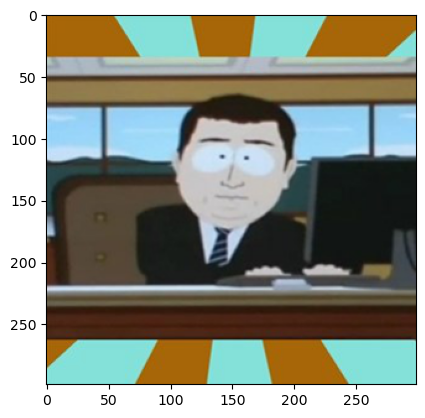

Caption 1: <start> had good idea for meme sep aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had my chance to hit it sep aaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> wild abra appears sep aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> just got paid sep and its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> had really great dream last night sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


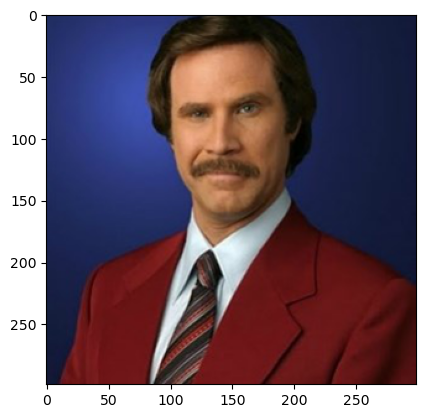

Caption 1: <start> toronto has lead sep aaaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> just found out about flappy bird sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> here is obama with your tax payers money sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> ve got good idea sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> had some hope sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


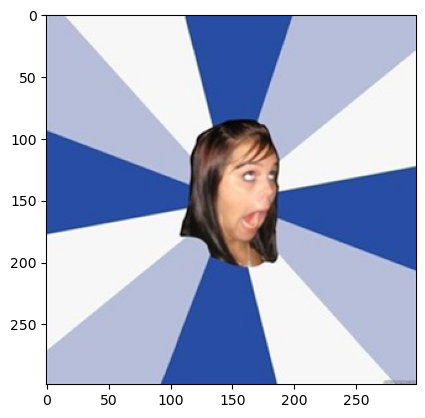

Caption 1: <start> october is here sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> the mets have the lead going into the inning sep aaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> just got my paycheck sep aaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> ll just load save sep annddd surrounded by deathclaws <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> moment ago felt compelled to do something nice for you sep and it gone <end> <pad> <pad> <pad> <pad> <pad>


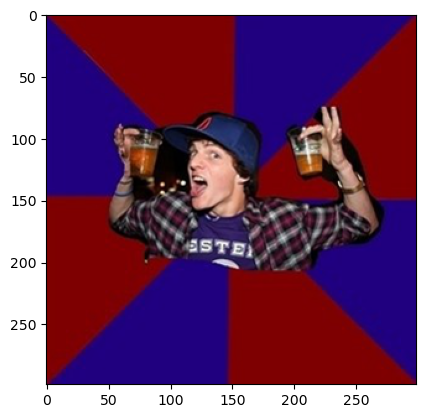

Caption 1: <start> here some nice really warm weather sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> you made another religious post sep aaaaaand you re gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> ll just look up my respect for you sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> okay just go inside go to the deli get the meat and cheese sep aaannd forgot my wallet <end> <pad>
Caption 5: <start> twinkies sep aaaand they re gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


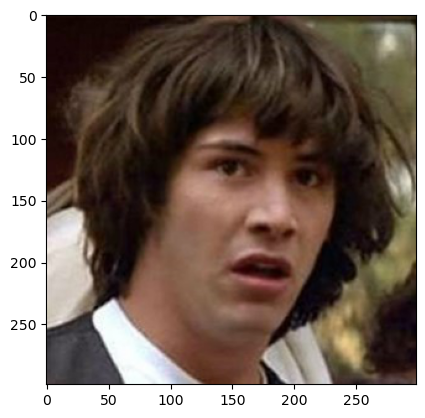

In [6]:
for i in range(5):
    for j in range(5):
        print(f'Caption {j+1}:', ' '.join([idx2word[idx] for idx in train_captions[i * 5 + j]]))
    plt.imshow(train_images[i * 5])
    plt.show()

### Running your RNN model

Depending on your use cases, you may choose to structure your model in a variety of ways. In contrast to previous assignments, this one is intended to mimic a lot of modern research-oriented repositories you might find in the wild. Specifically: **Instead of providing easy-to-use APIs for experimenters, they rigidify their implementation to make tests replicable.** Specifically, they may provide a command-line interface and define testing/training procedures which log results. 

(I mean, ideally you can make a flexible API and allow for both ease of extension and examples to demonstrate how your results were gathered, but sometimes researchers only have so much time...)

Once you have filled in the `model.py` components and the `RNNDecoder` of the `decoder.py` file, run this block to train your RNN model. As you can see, the hyperparamets default to the ones you use in `assignment.py`'s argparse specification, but feel free to change any of them to try to improve your model. 




In [7]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type rnn --task train --data ../memes900k/data.p --epochs 1 --chkpt_path ../rnn_model
## if using colab, you may need to do something like the following or might need to %cd into the directory of interest first...

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.201	 acc: 0.184	 perp: 493.386
[Valid 2/30]	 loss=6.043	 acc: 0.186	 perp: 421.009
[Valid 3/30]	 loss=6.033	 acc: 0.196	 perp: 417.044
[Valid 4/30]	 loss=6.180	 acc: 0.198	 perp: 482.996
[Valid 5/30]	 loss=6.169	 acc: 0.202	 perp: 477.634
[Valid 6/30]	 loss=6.155	 acc: 0.208	 perp: 471.022
[Valid 7/30]	 loss=6.143	 acc: 0.206	 perp: 465.318
[Valid 8/30]	 loss=6.130	 acc: 0.214	 perp: 459.581
[Valid 9/30]	 loss=6.135	 acc: 0.210	 perp: 461.969
[Valid 10/30]	 loss=6.151	 acc: 0.208	 perp: 469.125
[Valid 11/30]	 loss=6.140	 acc: 0.202	 perp: 463.900
[Valid 12/30]	 loss=6.082	 acc: 0.199	 perp: 437.731
[Valid 13/30]	 loss=6.092	 acc: 0.198	 perp: 442.364
[Valid 14/30]	 loss=6.135	 acc: 0.198	 perp: 461.906
[Valid 15/30]	 loss=6.114	 acc: 0.197	 perp: 452.009
[Valid 16/30]	 loss=6.105	 acc: 0.196	 perp: 447.922
[Valid 17/30]	 loss=6.096	 acc: 0.193	 perp: 443.983
[Valid 18/30]	 loss=6.094	 acc: 0.196	 perp: 4

2024-05-04 08:15:09.154346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-04 08:16:29.298444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




### Running your Transformer model

Once you have completed the `transformer.py` file, run this block to train your transformer based model. Note that running with the `both` task will both train, save, and test your model in one go.

In [6]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type transformer --task train --data ../memes900k/data.p --epochs 10 --lr 0.0005 --chkpt_path ../transform_model

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.297	 acc: 0.168	 perp: 543.160
[Valid 2/30]	 loss=6.176	 acc: 0.170	 perp: 480.914
[Valid 3/30]	 loss=6.148	 acc: 0.181	 perp: 467.974
[Valid 4/30]	 loss=6.268	 acc: 0.178	 perp: 527.585
[Valid 5/30]	 loss=6.264	 acc: 0.181	 perp: 525.268
[Valid 6/30]	 loss=6.252	 acc: 0.182	 perp: 519.265
[Valid 7/30]	 loss=6.241	 acc: 0.182	 perp: 513.514
[Valid 8/30]	 loss=6.238	 acc: 0.187	 perp: 512.019
[Valid 9/30]	 loss=6.249	 acc: 0.184	 perp: 517.750
[Valid 10/30]	 loss=6.263	 acc: 0.183	 perp: 524.727
[Valid 11/30]	 loss=6.245	 acc: 0.179	 perp: 515.461
[Valid 12/30]	 loss=6.195	 acc: 0.174	 perp: 490.469
[Valid 13/30]	 loss=6.206	 acc: 0.174	 perp: 495.582
[Valid 14/30]	 loss=6.245	 acc: 0.173	 perp: 515.396
[Valid 15/30]	 loss=6.225	 acc: 0.172	 perp: 505.240
[Valid 16/30]	 loss=6.217	 acc: 0.171	 perp: 501.050
[Valid 17/30]	 loss=6.207	 acc: 0.170	 perp: 496.001
[Valid 18/30]	 loss=6.205	 acc: 0.172	 perp: 4

2024-05-02 12:40:07.408766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-02 12:41:08.969916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.





## Visualization

After training our Transformer model, you can visualize the self-attention layer to examine the behavior of your attention heads and see if any patterns emerge. 

To test out the components of the model interactively, you'll need to deconstruct selections of the model/runner code and get an instance of the model in an interactive context (aka inside the notebook). 



In [8]:
## Feel free to insert auto-reloads as necessary
from main import parse_args, load_model
from decoder import TransformerDecoder, RNNDecoder

## Pull your model into the notebook. This is heavily based off of assignment.py, 
## and feel free to reuse as much as you want. Your final project will probably 
## involve a lot of this investigative reverse-engineering based on what repos 
## you have to stumble upon.
## You're not in a notebook scenario, so use get_default_arguments and feel free to update it...

args = parse_args('--type rnn --task both --data ../memes900k/data.p'.split())

args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)

args.chkpt_path = '../rnn_model'
rnn_imcap = load_model(args)





Model loaded from '../transform_model'
Model loaded from '../rnn_model'


In [9]:
rnn_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_decoder (RNNDecoder)    multiple                  7318254   
                                                                 
Total params: 7318254 (27.92 MB)
Trainable params: 7318254 (27.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
tra_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder (Trans  multiple                  7408554   
 formerDecoder)                                                  
                                                                 
Total params: 7408554 (28.26 MB)
Trainable params: 7408554 (28.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Caption Generation
Now that you have trained both of your models, it's time to use them to generate original captions for images in the testing set. First, the model is given the <start\> token and asked to generate probabilites for the next word in the sequence. The next token is chosen by sampling from that probability. This process repeats until the model generates the <end\> token, or the maximum sequence length is reached.

 



There is still one piece of this equation missing. The tokens are sampled from the probabilities your models generate, but your models were required to output logits, not probabilities. This is becasue this assignment, like many NLP models, uses temperature as a parameter in text generation. If the models sampled from  probabilies calculated by simply applying softmax to the logits, then the probability of the most likely word will usually be very high and the models will usually genrate the same, most probable caption every time. We use the temperature as a parameter to even out the probabilites so the model produces more 'creative' captions. This is done by dividing the logits by the temperature parameter before applying softmax. Higher temprature values will give a more creative captiong, while temprature values closer to 0 will be more greedy. Check out [this](https://lukesalamone.github.io/posts/what-is-temperature/) article for a demonstration and further explaination of temprature in NLP models.


In [10]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding. 
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input)
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])

## Generating Sentences for Training Data 

In [11]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 500, 5))), 10, replace=False)
for i in indices:
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in train_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

C1: maybe should check my symptoms on web md sep aaaaand it cancer
C2: here let me go get one the fucks that give sep aaaand it gone
C3: saved money sep and it gone
C4: league of legends servers are stable again sep aaaaand it down
C5: we still have our freedoms sep aaand it gone
RNN: sep you


NameError: name 'tra_imcap' is not defined

### Trying out on things in testing set!

sep you Offensive score:  0.197


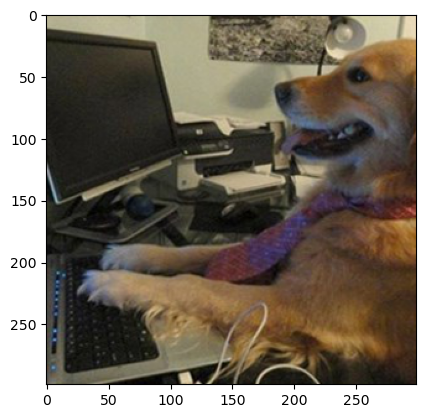

sep you Offensive score:  0.197


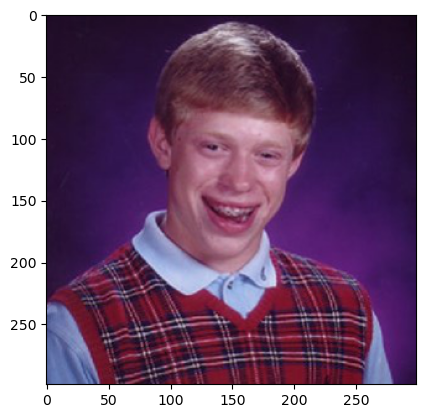

sep you Offensive score:  0.197


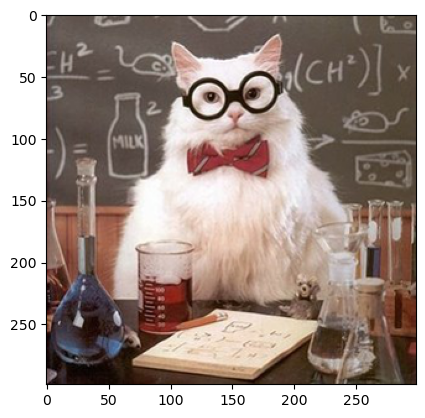

sep you Offensive score:  0.197


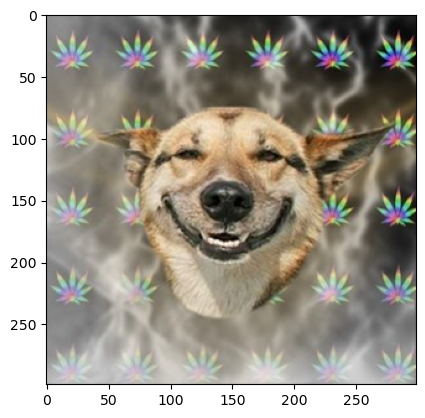

sep you Offensive score:  0.197


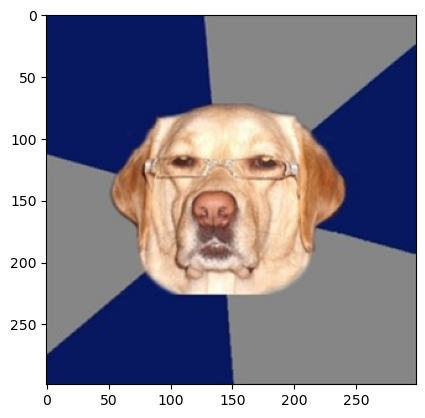

sep you Offensive score:  0.197


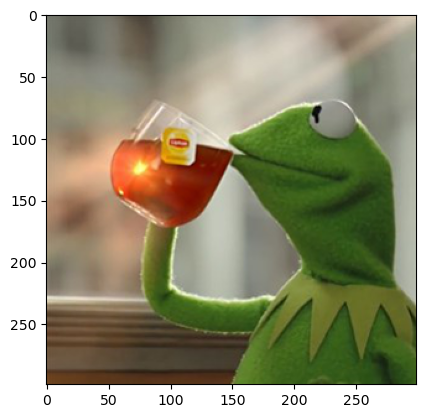

sep you Offensive score:  0.197


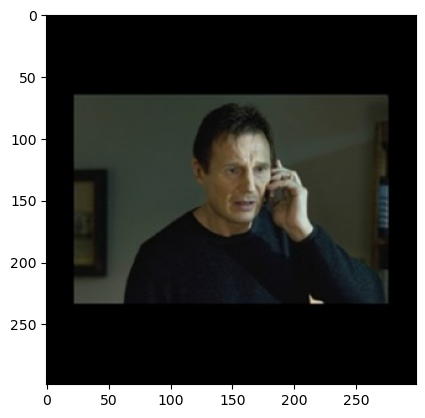

sep you Offensive score:  0.197


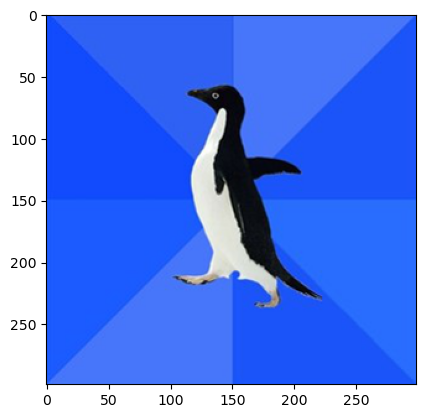

sep you Offensive score:  0.197


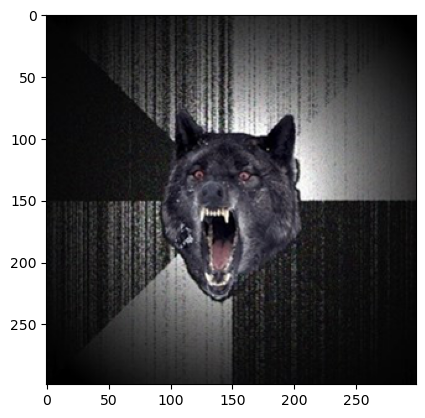

sep you Offensive score:  0.197


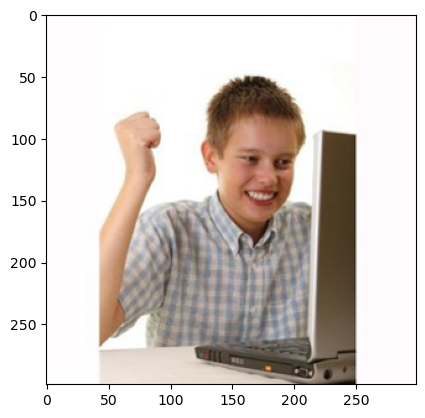

In [10]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 500, 5))), 10, replace=False)
rnn_captions = []
tra_captions = []

import warnings
warnings.filterwarnings("ignore", message=".*All model checkpoint layers were used.*")

for i in indices:
    curr_image_feat = test_img_feats[i]
    curr_image      = train_images[i]
    #rnn_caption = gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    #tra_caption = gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    #rnn_captions.append(rnn_caption)
    #tra_captions.append(tra_caption)
    #output = rnn_imcap.get_offensive_score("Here")
    text, offensive_score = rnn_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    print(text, "Offensive score: ", offensive_score)
    plt.imshow(curr_image)
    plt.show()

In [9]:
curr_image_feat = train_img_feats[95]
curr_image      = train_images[95]
#rnn_caption = gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
#tra_caption = gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
#rnn_captions.append(rnn_caption)
#tra_captions.append(tra_caption)
#output = rnn_imcap.get_offensive_score("Here")
text, offensive_score = tra_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
print(text, "Offensive score: ", offensive_score)
plt.imshow(curr_image)
plt.show()

NameError: name 'tra_imcap' is not defined

In [17]:
from filter_utils import print_captions_and_label
print_captions_and_label(tra_captions, "offensive")

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.
